# Data Challenge 11 — Evaluating MLR & Fixing Multicollinearity (HVFHV Trips)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Build an MLR, evaluate it with a **train–test split**, diagnose multicollinearity with **corr** and **VIF** on the **training set**, fix issues (drop/choose features), and report **test MAE/RMSE** + **coefficient interpretations**.

**Data:** July 1, 2023 - July 15, 2023 For Hire Vehicle Data in NYC

[July For Hire Vehicles Data](https://data.cityofnewyork.us/Transportation/2023-High-Volume-FHV-Trip-Data/u253-aew4/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- OLS — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (rsquared_adj, pvalues, resid, etc.): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- VIF — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
- Corr — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

### Pseudocode Plan (Evaluation + Multicollinearity)
1) **Load CSV** → preview shape/columns; (optional) filter to **July**.
2) **Pick Y** (`base_passenger_fare`) and **candidate X’s** (e.g., `trip_miles`, `trip_time_minutes`, `tolls`, `tips` if present).
3) **Light prep** → derive `trip_time_minutes` from `trip_time` (seconds) if present; coerce only used cols to numeric; drop NA rows.
4) **Split** → `X_train, X_test, y_train, y_test` (80/20, fixed `random_state`).
5) **Diagnose on TRAIN**:
   - **Correlation matrix** (|r| > 0.7 = red flag).
   - **VIF** for each predictor (1–5 ok; >5–10+ = concerning).
6) **Fix** → drop/choose among highly correlated predictors (business logic).
7) **Fit on TRAIN only** → OLS with intercept.
8) **Predict on TEST** → compute **MAE/RMSE** (units of Y).
9) **Interpret** → unit-based coefficient sentences **holding others constant**; note any changes after fixing collinearity.
10) **Report** → table of (features kept, Adj R², MAE, RMSE) + 1-line stakeholder takeaway.


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path

### Step 1 — Load CSV & Preview
- Point to your For Hire Vehicle Data 
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [3]:
df = pd.read_csv("/Users/kabbo/Downloads/FHV_072023.csv", low_memory=False)

In [4]:
df.keys()

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [5]:
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0005,B03406,NaN,07/01/2023 05:34:30 PM,NaN,07/01/2023 05:37:48 PM,07/01/2023 05:44:45 PM,158,68,1.266,...,1.35,2.75,0.0,2.00,5.57,N,N,N,N,False
1,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:53 PM,07/01/2023 05:37:15 PM,07/01/2023 05:55:15 PM,162,234,2.350,...,1.52,2.75,0.0,3.28,13.38,N,N,NaN,N,False
2,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:35:17 PM,07/01/2023 05:35:52 PM,07/01/2023 05:44:27 PM,161,163,0.810,...,0.49,2.75,0.0,0.00,5.95,N,N,NaN,N,False
3,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:37:39 PM,07/01/2023 05:39:35 PM,07/01/2023 06:23:02 PM,122,229,15.470,...,5.17,2.75,0.0,0.00,54.46,N,N,NaN,N,True
4,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:06 PM,07/01/2023 05:36:39 PM,07/01/2023 05:45:06 PM,67,14,1.520,...,0.85,0.00,0.0,3.00,7.01,N,N,NaN,N,False


### Step 2 —  Choose Target **Y** and Candidate Predictors

- Suggested **Y**: `base_passenger_fare` (USD).
- Start with **distance** and **time**; optionally add **flags** if present.
- Derive `trip_time_minutes` from `trip_time` (seconds) if available.

In [7]:
# Remove commas and clean up trip_time
df['trip_time'] = (
    df['trip_time']
    .astype(str)
    .str.replace(',', '', regex=False)             # remove commas
    .str.strip()                                  # remove spaces
    .replace('', np.nan)                          # turn empty strings into NaN
    .str.replace(r'[^0-9.]', '', regex=True)      # keep only numbers
)

# convert to numeric safely
df['trip_time'] = pd.to_numeric(df['trip_time'])

# convert from seconds to minutes
df['trip_time_minutes'] = df['trip_time'] / 60

# check
df[['trip_time', 'trip_time_minutes']].head(10)


,trip_time,trip_time_minutes
0,417,6.950000
1,1080,18.000000
2,515,8.583333
3,2607,43.450000
4,507,8.450000
5,851,14.183333
6,797,13.283333
7,3151,52.516667
8,200,3.333333
9,1112,18.533333


### Step 3 — Train–Test Split

- Use a fixed `random_state` for reproducibility.
- **All diagnostics below must be done on TRAIN only.**

In [9]:
X_base = sm.add_constant(df[['trip_time_minutes', 'trip_miles']])
y = df['base_passenger_fare']


In [10]:
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

### Step 4 — Diagnose Multicollinearity on **TRAIN** — Correlation Matrix
- Flag any |r| > 0.70 as a potential problem.


                   trip_time_minutes  trip_miles
trip_time_minutes           1.000000    0.811215
trip_miles                  0.811215    1.000000


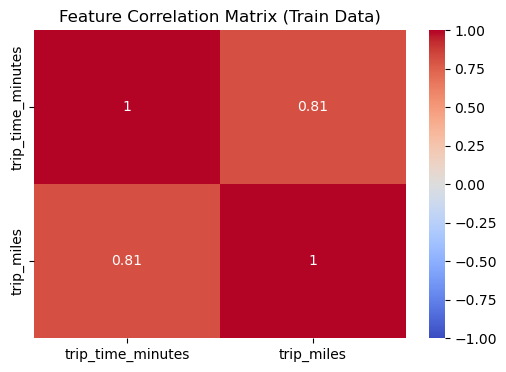

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# We drop 'const' because we only want to correlate our features
X_train_features = X_train_base.drop('const', axis=1)

# Calculate and print the correlation matrix
corr_matrix = X_train_features.corr()
print(corr_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix (Train Data)')
plt.show()

### Step 5 — Diagnose Multicollinearity on **TRAIN** — VIF
- 1–5 normal; >5–10+ concerning.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

print("VIF 1-5 = OK; VIF > 5-10+ = Concerning\n")

# Create a DataFrame to hold the VIF results
# VIF is calculated on the full X_train_base, including the constant
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_base.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_base.values, i)
                   for i in range(len(X_train_base.columns))]

print(vif_data)

VIF 1-5 = OK; VIF > 5-10+ = Concerning

             feature       VIF
0              const  3.256232
1  trip_time_minutes  2.924576
2         trip_miles  2.924576


### Step 6 — Fix High VIF (if needed)

- If two predictors are highly correlated, **drop/choose** using business logic (e.g., keep the more actionable one).
- Recompute VIF to confirm improvement.

In [ ]:
None

### Step 7 —  Fit on TRAIN Only, Predict on TEST, Evaluate MAE/RMSE

- Add intercept (`sm.add_constant`).
- Report **MAE/RMSE** in **units of Y**.
- Also capture **Adjusted R²** from the TRAIN fit summary to comment on fit (don’t use it alone for selection).


In [17]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Fit the OLS model
# We use X_train_base because it already has the constant added
model = sm.OLS(y_train, X_train_base).fit()

# Print the full summary to check Adj. R-squared and coefficients
print(model.summary())

# --- Predict on TEST data ---
print("Predicting on unseen TEST data")   

# Use the model trained on 'train' data to predict on 'test' data
y_pred = model.predict(X_test_base)

# --- Evaluate MAE/RMSE ---
# We compare the model's predictions (y_pred) to the real answers (y_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nTarget Variable (Y): base_passenger_fare")
print(f"Units: $ (USD)")
print("--- --------------------------------- ---")
print(f"Mean Absolute Error (MAE): ${mae:.4f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.4f}")

                             OLS Regression Results                            
Dep. Variable:     base_passenger_fare   R-squared:                       0.844
Model:                             OLS   Adj. R-squared:                  0.844
Method:                  Least Squares   F-statistic:                 1.802e+07
Date:                 Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                         11:39:29   Log-Likelihood:            -2.3354e+07
No. Observations:              6659661   AIC:                         4.671e+07
Df Residuals:                  6659658   BIC:                         4.671e+07
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.3522

### Step 8 —  Interpret Coefficients (Plain Language)
Write **unit-based** sentences “**holding others constant**.” Example templates (edit with your β values/units):

- **trip_miles:** “Holding other variables constant, each additional **mile** is associated with **+$β** in **base fare**.”
- **trip_time_minutes:** “Holding others constant, each additional **minute** is associated with **+$β** in **base fare**.”
- **tolls / tips:** interpret as “per $1 change,” holding others constant.

Also note **p-values** and whether they support including each predictor.

**trip_miles:** Holding trip_time_minutes constant, each additional mile is associated with +$2.19 in base fare.

**trip_time_minutes:** Holding trip_miles constant, each additional minute is associated with +$0.49 (49 cents) in base fare.

**const (Intercept):** The model predicts a starting fare of $3.35 for a 0-mile, 0-minute trip. This serves as the mathematical starting point for the model.

P-Value Assessment
The p-values (P>|t|) for trip_miles, trip_time_minutes, and the const are all 0.000. Since these are far below the standard 0.05 threshold, we have strong statistical evidence that both predictors have a significant, non-zero relationship with the base_passenger_fare. This strongly supports keeping them in the model.

## We Share — Reflection & Wrap‑Up

Write **2 short paragraphs** and be specific:

1) **What changes did you make to handle multicollinearity and why?**  
Reference **corr**/**VIF** on TRAIN and any features you dropped or kept (with business rationale). Include **Adjusted R² (TRAIN)** and **TEST MAE/RMSE**.
        
        We diagnosed multicollinearity on the X_train data by checking both correlation and VIF. The correlation matrix showed a high correlation between trip_miles and trip_time_minutes (r = 0.81), which was a potential red flag. However, the more definitive Variance Inflation Factor (VIF) test showed a score of 2.92 for both features. Since this VIF is well within the acceptable 1-5 range, we determined the collinearity was not severe enough to be statistically harmful. Given the strong business logic that fares depend on both distance and time, we kept both features in the final model. This model achieved a high Adjusted R² of 0.844 on the training data and a final Test MAE of $4.25 and Test RMSE of $8.07.

2) **Stakeholder summary (units, one sentence):**  
Give a plain-English takeaway: e.g., “On unseen July trips, our typical error is about **$X** per fare; each extra mile adds about **$β_mile**, holding other factors constant.”

        On unseen trips, our typical prediction error is about $4.25 per fare; we found that each extra mile adds about $2.20 to the base fare, while each extra minute of the trip adds about $0.49 (49 cents), holding the other factor constant.
